In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import interpolate as interp
from scipy import integrate 
from scipy import stats 
import astropy.constants as c
from tqdm import tqdm
import time


**PROBLEM 1**

*Derivation of the Electric Field equation*

The idea of the computation is to treat the electric field produced by a ring of the shell as $dq$ and sum all the rings' fields which adds up to the electric field of a spherical shell. The electric field of a ring is,

$E_{ring}=\frac{qZ}{4\pi\epsilon_0(Z^2+r^2)^{3/2}}$,    (1)
where q is the total charge on a ring, Z the vertical distance from the center of the ring and r the radius of the ring.

So, for the electric field of the spherical shell, $dE$ corresponds to the electric of each ring such that we use equation (1) as the integrand and rearrange the equation in spherical coordinates, with $R$ being the fixed radius of the sphere, $z$, the vertical distance from the center of the sphere, $\theta$ the angle defined between [0,$\pi$] and $\phi$ the angle defined between [0,$2\pi$]. The following points are the changes made on (1):

* Since q in (1) corresponds to dq for the spherical shell's E-field, and $dQ=\sigma dA$ given $\sigma$, the surface charge density of the shell, then
$q=dQ=\sigma dA$ and $dA=R^2sin(\theta)d(\theta)d(\phi)$

* Z in (1) corresponds to the vertical distance from the center of the ring; it can be easily shown with trigonometry that Z can be rewritten as $Z = z - Rcos(\theta)$, where z is the vertical distance from the center of the sphere

* The radius of a ring is redefined as $r=Rsin(\theta)$ and from above, $Z=z-Rcos(\theta)$, such that $(Z^2 + r^2)$ becomes $((z-Rcos(\theta))^2 + R^2sin^2(\theta))=(z^2-2zRcos(\theta)+R^2cos^2(\theta)+R^2sin^2(\theta))=(z^2-2zRcos(\theta)+R^2)$.

Using the above modifications to the integrand, we can write the electric field of the spherical shells as
$E_z=\int E_{ring}=\int_{\theta=0}^{\pi} \int_{\phi=0}^{2\pi} \frac{\sigma R^2sin(\theta)(z - Rcos(\theta))d(\theta)d(\phi)}{4\pi\epsilon_0(z^2-2zRcos(\theta)+R^2)^{3/2}}$, where $\int_{\phi=0}^{2\pi}d(\phi)=2\pi.$ Thus, to derive the electric field of a spherical shell, we compute the following integral,

$E_z=\int_{0}^{\pi} \frac{\sigma R^2sin(\theta)(z - Rcos(\theta))}{2\pi\epsilon_0(z^2-2zRcos(\theta)+R^2)^{3/2}}d(\theta)$


In [2]:
def E_field(theta,z,R,sigma):
    eps=c.eps0.value #permittivity value
    #see above for the derivation
    return 1/(2*np.pi*eps)*sigma*R**2*np.sin(theta)*(z-R*np.cos(theta))/((R**2+z**2-2*R*z*np.cos(theta))**(3/2)) 

In [3]:
#inspired from John's code
def integrator_E(fun,z,R,sigma,a,b,tol,i):
    if R==z:
        #warning that we encounter a singularity, and print the index of where it is at
        print('Singularity for z=R encountered at index {} of z array; returned value is none.'.format(i))
        return None
        
        
    x=np.linspace(a,b,5)
             
    dx=x[1]-x[0]
    y=fun(x,z,R,sigma) #compute the function for the 5 points
    #do the 3-point integral
    i1=(y[0]+4*y[2]+y[4])/3*(2*dx)
    #do the 5-point integral
    i2=(y[0]+4*y[1]+2*y[2]+4*y[3]+y[4])/3*dx
    myerr=np.abs(i1-i2)
    
    if myerr<tol: #if the error between the two integrals<tolerance, then subdivide the integral in 2 
        #and call the function recursively until the tolerance is satisfied
        return i2
    else:
        mid=(a+b)/2 #the mid point becomes b of the left interval and a of the right interval
        int1=integrator_E(fun,z,R,sigma,a,mid,tol/2,i)
        int2=integrator_E(fun,z,R,sigma,mid,b,tol/2,i)
        return int1+int2



In [32]:
def my_integrator(fun,z,R,sigma,a,b,tol=1,method=1):
    #The function assumes scipy method (i.e. method=1) to compute the integral
    #If method is set to 2, the integrator is used to compute the integral
    
    if method==1: #compute with quad
        z_interg = np.zeros((len(z),2))
        for i in range(len(z)):
                #Compute a definite integral.
                #Integrates from a to b using a technique from the Fortran library QUADPACK.
                z_interg[i,0],z_interg[i,1] = integrate.quad(fun,a,b,args=(z[i],R,sigma))
                #integral value  #error
        return z_interg #returns the integrals and associated errors
    
    else: #computes with the integrator
        singularity=False #initiate presence of singularity to false 
        z_interg = np.zeros((len(z),1))
        for i in range(len(z)):
            z_interg[i] = integrator_E(E_field,z[i],R,sigma,a,b,tol,i) #integrate at value z
            if np.isnan(z_interg[i]):
                singularity=True #set presence of singularity to true
                #warn that no value is stored at the singularity point, and a new z array is returned
                print('Integration is not performed for the singularity point and is removed from the z-array.')
                ind_sing = i #index of the singularity
        
        #remove the singularity points from the z array
        if singularity:
            z=np.delete(z,ind_sing)
            z_interg=np.delete(z_interg,ind_sing)
        return z_interg,z #returns the integrals and the z array (which might me modified if singularity=True)

Computing the electric field using scipy.quad:


/var/folders/0q/ylrzgj790xx8_v0hq__m6kbw0000gn/T/ipykernel_22987/3559086495.py:10: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  z_interg[i,0],z_interg[i,1] = integrate.quad(fun,a,b,args=(z[i],R,sigma))


Time required for the integrate.quad to compute the electric field is 0.627s

Computing the electric field using my integrator:
Singularity for z=R encountered at index 200 of z array; returned value is none.
Integration is not performed for the singularity point and is removed from the z-array.
Time required for the integrator to compute the electric field is 7.127s


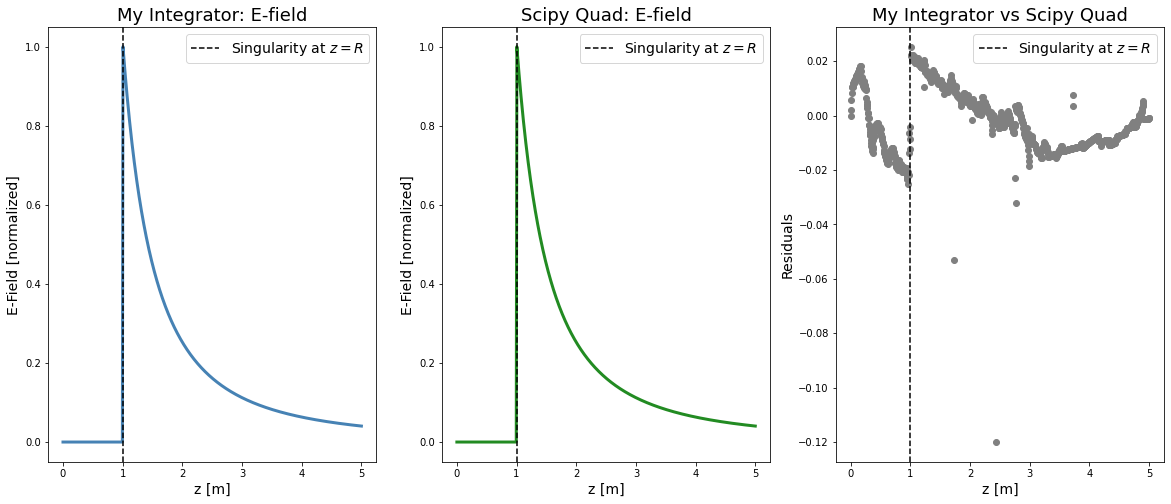

In [33]:
#Test the above functions

R=1
sigma=0.02
z_interval = [0,5]
theta_interval = [0,np.pi]
zz = np.linspace(z_interval[0],z_interval[1],1001)
print('Computing the electric field using scipy.quad:')
start = time.time()
z_interg1 = my_integrator(E_field,zz,R,sigma,theta_interval[0],theta_interval[1])
stop = time.time()
print('Time required for the integrate.quad to compute the electric field is {}s'.format(round(stop-start,3)))
print('\nComputing the electric field using my integrator:')
start = time.time()
z_interg2,z2 = my_integrator(E_field,zz,R,sigma,theta_interval[0],theta_interval[1],method=2)
stop = time.time()
print('Time required for the integrator to compute the electric field is {}s'.format(round(stop-start,3)))

fig,axs=plt.subplots(1,3,figsize=(20,8))

axs[0].plot(z2,z_interg2/max(z_interg2),color='steelblue',linewidth=3)
axs[0].set_title('My Integrator: E-field',fontsize=18)
axs[0].axvline(x=R,linestyle='--',linewidth=1.5,color='k',label='Singularity at $z=R$')
axs[0].set_ylabel('E-Field [normalized]',fontsize=14)
axs[0].set_xlabel('z [m]',fontsize=14)
axs[0].legend(fontsize=14)

axs[1].plot(zz,z_interg1[:,0]/max(z_interg1[:,0]),color='forestgreen',linewidth=3)
axs[1].axvline(x=R,linestyle='--',linewidth=1.5,color='k',label='Singularity at $z=R$')
axs[1].set_title('Scipy Quad: E-field',fontsize=18)
axs[1].set_ylabel('E-Field [normalized]',fontsize=14)
axs[1].set_xlabel('z [m]',fontsize=14)
axs[1].legend(fontsize=14)

axs[2].scatter(z2,z_interg2-np.hstack((z_interg1[:200,0],z_interg1[201:,0])),marker='o',color='gray')
axs[2].axvline(x=R,linestyle='--',linewidth=1.5,color='k',label='Singularity at $z=R$')
axs[2].set_title('My Integrator vs Scipy Quad',fontsize=18)
axs[2].set_ylabel('Residuals',fontsize=14)
axs[2].set_xlabel('z [m]',fontsize=14)
axs[2].legend(fontsize=14)




There is a singularity in the integral at $z=R$ as the denominator is zero for $\theta=0 \implies cos(\theta)=1 \implies z^2-2zRcos(\theta)+R^2 = R^2-2R^2+R^2 = 0$. Therefore, my integrator fails to evaluate the integral as it blows up to infinity for z=R and $\theta=0$, meaning that the 3 and 5 points simpson's rule integral evaluate to infinity (i.e. nan) such that the error tolerance will never be reached and the function will undergo infinite recursion. My integrator function avoids this issue by skipping the integral evaluation at the point z=R if it exists in the array. On the other hand, quad does not "care" about this singularity or rather, it uses routines that deal with singularities: FORTRAN library QUADPACK's routines are called by quad; where some are designed to deal with singularities/discontinuities or any type of difficulties in the integrand function such that we do not have to deal with them. In other words, quad does care for singularities as it deals with them "behind the scene" but we do not have to care for them when we use quad.

PROBLEM 2

The idea of the adaptive method of the integrator is to pass down the function values that are already evaluated in the first function calls and re-used in the sub-recursive calls.

On the first call of the function, the 5 x's evaluated are equally spread across the interval [a,b]:

[a-------$x_1$-------$x_2$-------$x_3$-------b] (1) Now, if the error between the 3 and 5 points Simpson's rule does not satisfies the tolerance, the interval is split in two:

[a-------$x_{11}$-------$x_1$-------$x_{12}$-------$x_2$] (2) + [$x_2$-------$x_{21}$-------$x_3$-------$x_{22}$-------b] (3), such that each points from (1) is re-used in (2) and (3) and 2 new points are evaluated in (2) as well as in (3). In other words, each points evaluated in the parent call are evaluated again along with 2 new points for the successive calls. 

The idea is therefore to store {$a,x_1,x_2$} for the left sub-interval call and {$x_2,x_3,b$} for the right sub-interval call. Naturally, on the first call of the function, the 5 points need to be evaluated; thereafter, 2 new points for each sub-intervals are evaluated. Hence, 3 function calls are saved per recursive calls (so 6 function calls are saved everytime the error is greater than the tolerance error and the function undergoes recursion).


In [6]:
#inspired from John's code
def integrate_adaptive(fun,a,b,tol,extra=None):
    x = np.linspace(a,b,5)
    dx = x[1]-x[0]
    if extra is not None: #i.e. not the first recursive call
        fcalls = extra[1] + 3 #3 more function calls are saved for every recursive call
        ynew = fun(x[1::2]) #evaluate for the two new x points
        y=np.array([extra[0][0],ynew[0],extra[0][1],ynew[1],extra[0][2]]) #y array with new points and saved points
    
    else: # i.e. the first call
        y=fun(x)
        fcalls=0
        
    #do the 3-point integral
    i1=(y[0]+4*y[2]+y[4])/3*(2*dx)
    #do the 5-point integral
    i2=(y[0]+4*y[1]+2*y[2]+4*y[3]+y[4])/3*dx
    err=np.abs(i1-i2)
    
    #similar method as commented above
    if err<tol:
        return i2,fcalls #returns the integral and the number of saved function calls
    else:
        mid=(a+b)/2
        int1,fcalls1=integrate_adaptive(fun,a,mid,tol/2,extra=(y[:3],fcalls))
        int2,fcalls2=integrate_adaptive(fun,mid,b,tol/2,extra=(y[2:],fcalls))

        return int1+int2,fcalls1+fcalls2 #returns the integral and the number of saved function calls of the 
                                            #2 sub-intervals

        

We can run some tests to see how many function calls are saved for different integrand functions.

Function test: sin


Text(0.5, 0, 'Integral length [b-a]')

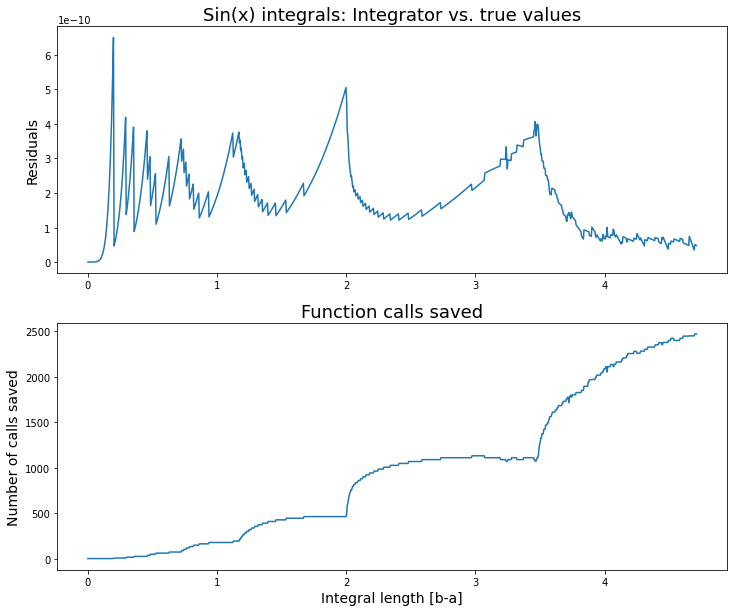

In [17]:
print('Function test: sin')
x_test = np.linspace(-np.pi,np.pi/2,1001)
int_length = np.array([(x-x_test[0]) for x in x_test])
sin_integ_true=np.array([(-np.cos(x)+np.cos(x_test[0])) for x in x_test])
sin_integ=np.empty([len(x_test),2])
for i in range(len(x_test)):
    sin_integ[i,0] = integrate_adaptive(np.sin,x_test[0],x_test[i],1e-8)[0]
    sin_integ[i,1] = integrate_adaptive(np.sin,x_test[0],x_test[i],1e-8)[1]

fig,axs=plt.subplots(2,figsize=(12,10))
axs[0].plot(int_length,sin_integ_true-sin_integ[:,0])
axs[0].set_title('Sin(x) integrals: Integrator vs. true values',fontsize=18)
axs[0].set_ylabel('Residuals',fontsize=14)
axs[1].plot(int_length,sin_integ[:,1])
axs[1].set_title('Function calls saved',fontsize=18)
axs[1].set_ylabel('Number of calls saved',fontsize=14)
axs[1].set_xlabel('Integral length [b-a]',fontsize=14)
                   

Function test: exp


Text(0.5, 0, 'Integral length [b-a]')

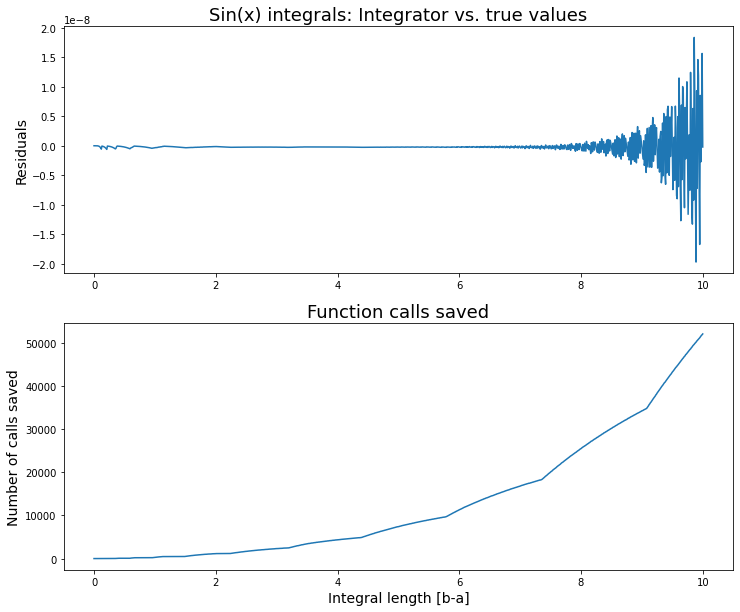

In [18]:
print('Function test: exp')
x_test = np.linspace(0,10,1001)
int_length = np.array([(x-x_test[0]) for x in x_test])
exp_integ_true=np.array([(np.exp(x)-np.exp(x_test[0])) for x in x_test])
exp_integ=np.empty([len(x_test),2])

for i in range(len(x_test)):
    exp_integ[i,0] = integrate_adaptive(np.exp,x_test[0],x_test[i],1e-8)[0]
    exp_integ[i,1] = integrate_adaptive(np.exp,x_test[0],x_test[i],1e-8)[1]

fig,axs=plt.subplots(2,figsize=(12,10))
axs[0].plot(int_length,exp_integ_true-exp_integ[:,0])
axs[0].set_title('Exp(x) integrals: Integrator vs. true values',fontsize=18)
axs[0].set_ylabel('Residuals',fontsize=14)
axs[1].plot(int_length,exp_integ[:,1])
axs[1].set_title('Function calls saved',fontsize=18)
axs[1].set_ylabel('Number of calls saved',fontsize=14)
axs[1].set_xlabel('Integral length [b-a]',fontsize=14)
                   


 First, we notice that the integrator accuracy falls within our tolerance factor, which is expected. For the exponential, the errors seem to get larger at larger interval ranges. For the sinusoidal, it seems like the errors might follow a periodic pattern (which makes sense for a periodic function).
 
 Second, we observe that for both functions, the number of calls saved get larger as the interval gets larger. This is expected as more recursive calls are gonna be made for larger intervals (hence more function evaluations). For the sinusoidal, the number of calls saved seem to follow an increasing "step" pattern, whereas for the exponential, the number of calls saved seem to get exponentially bigger. 
 
 We can conclude that the adaptive method becomes more important when evaluating complicated and computationally heavy functions as the number of "waisted" functions calls can be very significant.

**PROBLEM 3**

A Chebyshev polynomial is used to model the function. The function can be written as a Chebyshev expansion such that $f(x) = \sum c_iT_i(x)$, where the $T_i$ is the $i^{th}$ Chebyshev polynomial (defined as $T_{i+1} = 2xT_i-T_{i-1}$; $T_0=1$ and $T_1=x$) and $c_i$ is the $i^{th}$ Chebyshev coefficient. Chebyshev polynomials are bounded by -1 and 1 in the domain and co-domain so we can easily re-scale the function between this range to fit Chebyshev polynomials. We can fit a Chebyshev expansion with a high degree and truncate to some lower degree as for smooth functions, the Chebyshev coefficients drop smoothly. Moreover, as $T_i$'s are bounded (such that the errors are only as big as the coefficients), the maximum error is the sum of the cut coefficients. 

Using this knowledge, $log_2(x)$ for x $\in$ [0.5,1]  is fitted with Chebyshev polynomials using a least square fit of Chebyshev series to many x/y values to return the Chebyshev coefficients. We first fit to a high order and then truncate up to our accuracy tolerance (i.e. $10^{6}$).

In [26]:
def rescale(a,b,x):
    return (x-(1/2)*(b+a))/((1/2)*(b-a)) #scale between -1 and 1

def rescale2(a,b,y):
    return (1/2)*(b-a)*y + (1/2)*(b+a) #scale from -1 to 1 back to a,b

def cheblog2(a,b,order,n_use):
    fun = np.log2
    
    x=np.linspace(a,b,1001)
    y=fun(x) #true values
    
    #rescale
    x_rescaled = rescale(a,b,x)
    ay=y[0];by=y[-1]
    y_rescaled = rescale(ay,by,y)
    
    
    chebs_coeff=np.polynomial.chebyshev.chebfit(x_rescaled,y_rescaled,order) #computes the chebyshev coefficients
    chebs_coeff_use=chebs_coeff.copy()
    chebs_coeff_use[n_use:]=0 #truncate to the desired order
    chebs_fit=np.polynomial.chebyshev.chebval(x_rescaled,chebs_coeff_use)#evaluate the points with chebyshev coeffs
    chebs_fit_rescaled=rescale2(ay,by,chebs_fit) #scale back to a,b

    return chebs_fit_rescaled


Text(0, 0.5, 'Errors')

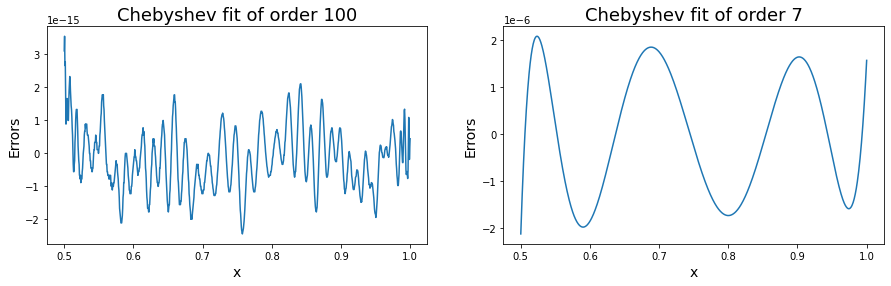

In [43]:
#Test the chebyshev expansion and truncation
a=0.5;b=1
order=100 #high order
x=np.linspace(a,b,1001)
y=np.log2(x)
y_chebs=cheblog2(a,b,order,order+1) #without truncation
y_chebsmod=cheblog2(a,b,order,7) #with truncation --> order 7


fig,axs=plt.subplots(1,2,figsize=(15,4))
axs[0].plot(x,y-y_chebs)
axs[0].set_title('Chebyshev fit of order 100',fontsize=18)
axs[0].set_xlabel('x',fontsize=14)
axs[0].set_ylabel('Errors',fontsize=14)

axs[1].plot(x,y-y_chebsmod)
axs[1].set_title('Chebyshev fit of order 7',fontsize=18)
axs[1].set_xlabel('x',fontsize=14)
axs[1].set_ylabel('Errors',fontsize=14)


From above, we observe that we can truncate the Chebyshev series to the seventh order to remain in an accuracy of $10^{-6}$. The Chebyshev expansion of order 7 is then used to approximate the natural log of a positive number.

To approximate the natural log of any positive number, we can use the logarithm change of base law:

$log_m(x) = \frac{log_n(x)}{log_n(m)}$. In our case, we have, $log_e(x) = \frac{log_2(x)}{log_2(e)}$. 

We can rewrite any number by decomposing it into a mantissa and twos exponent, i.e. $x=m*2^{e}$. This is done by using numpy frexp function. For $x\in (0,\infty_+)$, $m\in[0.5,1]$ and $e$ is a real positive number.

Now, we can rewrite $log_2(x)$ as $log_2(m*2^{e}) = log_2(m)+elog_2(2) = log_2(m) + e$ and compute $log_2(e)$ similarly. This way, we have,

$log_{exp}(x) = \frac{log_2(x)}{log_2(exp)} = \frac{log_2(m_x) + e_x}{log_2(m_{exp}) + e_{exp}}$, where $m_x, e_x$ are the mantissa and exponent of x and $m_x, e_x$ are the mantissa and exponent for the number e.

Then, the Chebyshev expansion for $log_2$ is used to compute the above equation and approximate the natural log of any positive number (excluding 0).


In [45]:
#similar function as above, but evaluate for x 
def chebl2(x_ev):
    a=0.5;b=1
    order=8
    fun = np.log2
    
    x=np.linspace(a,b,1001)
    y=fun(x)
    
    #rescale
    x_rescaled = rescale(a,b,x)
    x_ev = rescale(a,b,x_ev)
    ay=y[0];by=y[-1]
    y_rescaled = rescale(ay,by,y)
    
    
    chebs_coeff=np.polynomial.chebyshev.chebfit(x_rescaled,y_rescaled,order)
    chebs_fit=np.polynomial.chebyshev.chebval(x_ev,chebs_coeff)
    chebs_fit_rescaled=rescale2(ay,by,chebs_fit)
    
    return chebs_fit_rescaled


def mylog2(x):
    
    man,exp = np.frexp(x) #decomposition of x
    man_e,exp_e = np.frexp(np.exp(1)) #decomposition of exp
    log2_e = exp_e + chebl2(man_e) #see formula derived above
    
    return (exp+chebl2(man))/log2_e #returns the natural log of a positive number
    
    

Test to some wide range of positive numbers

Text(0, 0.5, 'Errors')

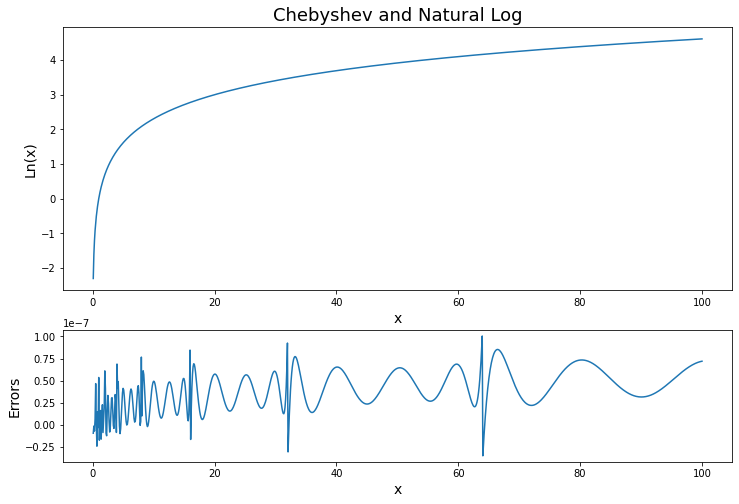

In [51]:
x = np.linspace(0.1,100,1001)
ln_true = np.log(x)
ln_cheb = mylog2(x)

fig,axs=plt.subplots(2,figsize=(12,8),gridspec_kw={'height_ratios':[2,1]})
axs[0].plot(x,ln_cheb)
axs[0].set_title('Chebyshev and Natural Log',fontsize=18)
axs[0].set_xlabel('x',fontsize=14)
axs[0].set_ylabel('Ln(x)',fontsize=14)

axs[1].plot(x,ln_true-ln_cheb)
axs[1].set_xlabel('x',fontsize=14)
axs[1].set_ylabel('Errors',fontsize=14)

We observe that the natural log approximation using the Chebyshev approximation of log base 2 is about as accurate as the tolerance we input for the expansion of log base 2.